In [1]:
import pandas as pd
import urllib.request
import os
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage import io
import numpy as np
import random
from skimage.filters.rank import entropy
from skimage import io

from skimage.morphology import disk
import umap.umap_ as umap
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Jenny\AppData\Roaming\Python\Python37\site-packages\umap_learn-0.4.2-py3.7.egg\umap\spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets
c:\users\jenny\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Working with Averaged Entropy

In [5]:
meta = pd.read_csv('metadata.csv')
meta.head()

,Unnamed: 0,cover_id,title,author,year,genre,genre_alts,pixel_count,mean_brightness,mean_hue,mean_saturation,entropy
0,257,5010523,DiscoveryWorks,William Badders,NaN,Science,"['Science', 'Study and teaching']",21248,0.801393,0.270078,0.682315,123102.384766
1,328,7225312,Chemicals of Life,Isaac Asimov,NaN,Science,"['organic chemistry', 'Biology', 'Biochemistry...",139000,0.303683,0.189660,0.716836,619915.788392
2,375,28269,The Curious Life of Robert Hooke,Lisa Jardine,NaN,Science,"['History', 'Science', 'Accessible book', 'Pro...",150575,0.321481,0.134043,0.225062,573382.454617
3,96,310408,"One, two, three ... infinity",George Gamow,NaN,Science,"['Science', 'Accessible book', 'physics', 'Pro...",141550,0.468131,0.503024,0.735062,514384.933285
4,136,1173785,How to Write and Publish a Scientific Paper,Robert A. Day,NaN,Science,"['Wetenschappelijke publicaties', 'Protected D...",151500,0.417190,0.456612,0.576622,679999.039310


In [14]:
var_meta = pd.read_csv('var_meta.csv')
var_meta.head()

,genre,cover_id,var_brightness,var_hue,var_saturation
0,Science,5010523,0.050718,0.043646,0.099580
1,Science,7225312,0.018357,0.006071,0.021354
2,Science,28269,0.169850,0.050173,0.095091
3,Science,310408,0.161568,0.006923,0.073171
4,Science,1173785,0.057811,0.077953,0.103576


In [5]:
#gets entropy
def get_entropy(image_file):
    img = io.imread(image_file)
    gray_img = rgb2gray(img)
    entr_img = entropy(gray_img, disk(10))
    return (np.mean(entr_img))

In [7]:
def mean_entropy(meta_df, folder):
    entropy = []
    for coverid in meta_df['cover_id']:
        if coverid == 'None':
            continue
       
        filename = "{}/{}.jpg".format(folder,coverid)
        entropy.append(get_entropy(filename))
    meta_df['entropy'] = entropy

    return meta_df

In [8]:
meta_entropy = download_images(meta, 'image2')

c:\users\jenny\appdata\local\programs\python\python37\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


In [9]:
meta_entropy.head()

,Unnamed: 0,cover_id,title,author,year,genre,genre_alts,pixel_count,mean_brightness,mean_hue,mean_saturation,entropy
0,257,5010523,DiscoveryWorks,William Badders,NaN,Science,"['Science', 'Study and teaching']",21248,0.801393,0.270078,0.682315,5.793599
1,328,7225312,Chemicals of Life,Isaac Asimov,NaN,Science,"['organic chemistry', 'Biology', 'Biochemistry...",139000,0.303683,0.189660,0.716836,4.459826
2,375,28269,The Curious Life of Robert Hooke,Lisa Jardine,NaN,Science,"['History', 'Science', 'Accessible book', 'Pro...",150575,0.321481,0.134043,0.225062,3.807953
3,96,310408,"One, two, three ... infinity",George Gamow,NaN,Science,"['Science', 'Accessible book', 'physics', 'Pro...",141550,0.468131,0.503024,0.735062,3.633945
4,136,1173785,How to Write and Publish a Scientific Paper,Robert A. Day,NaN,Science,"['Wetenschappelijke publicaties', 'Protected D...",151500,0.417190,0.456612,0.576622,4.488443


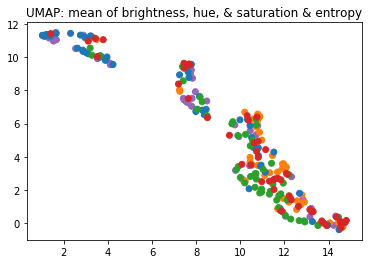

In [13]:
d = {'Horror':1, 'Crime': 0, 'Romance': 2, 'Fantasy':3, 'Science':4}

cover_data = meta_entropy[['mean_brightness', 'mean_hue', 'mean_saturation', 'entropy']]
cover_target = meta_entropy['genre'].map(d, na_action='ignore')

reducer = umap.UMAP()
embedding = reducer.fit_transform(cover_data)
                                 
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in cover_target])
plt.gca().set_aspect('auto','box')
plt.title('UMAP: mean of brightness, hue, & saturation & entropy', fontsize=12)
plt.savefig('graphs/umap_no_entropy_Romance_Science.png', dpi = 100)

# Merging Variance and Mean 

In [16]:
merge_meta = var_meta.merge(meta_entropy, on = 'cover_id')

In [17]:
merge_meta.head()

,genre_x,cover_id,var_brightness,var_hue,var_saturation,Unnamed: 0,title,author,year,genre_y,genre_alts,pixel_count,mean_brightness,mean_hue,mean_saturation,entropy
0,Science,5010523,0.050718,0.043646,0.099580,257,DiscoveryWorks,William Badders,NaN,Science,"['Science', 'Study and teaching']",21248,0.801393,0.270078,0.682315,5.793599
1,Science,7225312,0.018357,0.006071,0.021354,328,Chemicals of Life,Isaac Asimov,NaN,Science,"['organic chemistry', 'Biology', 'Biochemistry...",139000,0.303683,0.189660,0.716836,4.459826
2,Science,28269,0.169850,0.050173,0.095091,375,The Curious Life of Robert Hooke,Lisa Jardine,NaN,Science,"['History', 'Science', 'Accessible book', 'Pro...",150575,0.321481,0.134043,0.225062,3.807953
3,Science,310408,0.161568,0.006923,0.073171,96,"One, two, three ... infinity",George Gamow,NaN,Science,"['Science', 'Accessible book', 'physics', 'Pro...",141550,0.468131,0.503024,0.735062,3.633945
4,Science,1173785,0.057811,0.077953,0.103576,136,How to Write and Publish a Scientific Paper,Robert A. Day,NaN,Science,"['Wetenschappelijke publicaties', 'Protected D...",151500,0.417190,0.456612,0.576622,4.488443


In [19]:
merge_data = merge_meta[['mean_brightness', 'mean_hue', 'mean_saturation', 'entropy', 'var_brightness', 'var_hue', 'var_saturation']]

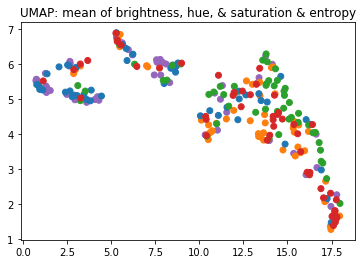

In [20]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(merge_data)
                                 
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in cover_target])
plt.gca().set_aspect('auto','box')
plt.title('UMAP: mean of brightness, hue, & saturation & entropy', fontsize=12)
plt.savefig('graphs/umap_no_entropy_Romance_Science.png', dpi = 100)

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import umap

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [3]:
def calc_feature_vector (coverid_list, folder): 
    feature_vector = []

    for coverid in coverid_list:
        if coverid == 'None':
            continue
        filename = "{}/{}.jpg".format(folder,coverid)
        image = load_img(filename, target_size=(224, 150))
        feature_vector.append(cnn_feature_vector(image))
    return feature_vector

def cnn_feature_vector(img):
    model = VGG16(weights='imagenet', include_top=False)
    image = img_to_array(img)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    vgg16_feature = model.predict(image)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_vector = vgg16_feature_np.flatten()
    return vgg16_feature_vector

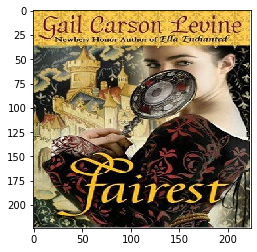

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


25088

In [25]:
filename = 'image2/33377.jpg'
image = load_img(filename, target_size=(224,224))
plt.imshow(image)
plt.show()



In [27]:
v = cnn_feature_vector(image)

In [54]:
feature_df1 = pd.DataFrame(calc_feature_vector(merge_meta['cover_id'][:50], 'image2'))
feature_df1['genre'] = merge_meta['genre_x'][:50]
feature_df1.to_csv('feature1.csv', index = False)

In [5]:
feature_df2 = pd.DataFrame(calc_feature_vector(meta['cover_id'][50:100], 'image2'))
feature_df2['genre'] = meta['genre'][50:100]
feature_df2.to_csv('feature2.csv', index = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
feature_df3 = pd.DataFrame(calc_feature_vector(meta['cover_id'][100:150], 'image2'))
feature_df3['genre'] = meta['genre'][100:150]
feature_df3.to_csv('feature3.csv', index = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
feature_df4 = pd.DataFrame(calc_feature_vector(meta['cover_id'][150:200], 'image2'))
feature_df4['genre'] = meta['genre'][150:200]
feature_df4.to_csv('feature4.csv', index = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
feature_df5 = pd.DataFrame(calc_feature_vector(meta['cover_id'][200:250], 'image2'))
feature_df5['genre'] = meta['genre'][200:250]
feature_df5.to_csv('feature5.csv', index = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
feature_df5 = feature_df5[:50]
feature_df5['genre'] = meta['genre'][200:250].to_list()
feature_df5.head()

c:\users\jenny\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Fantasy
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,10.467566,0.0,0.0,0.0,20.599642,7.667212,0.0,0.000000,15.887252,Fantasy
2,0.0,0.0,1.554977,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,Fantasy
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,31.075239,0.0,0.0,0.0,0.000000,0.000000,0.0,13.866982,0.000000,Fantasy
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.196437,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.264358,0.000000,Fantasy


In [36]:
feature_df1 = pd.read_csv('feature1.csv')
feature_df1.head()

,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.000000,0.0,0.000000,0.0,0.0,0.930601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
2,0.305162,0.0,59.545147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
4,0.000000,0.0,0.000000,0.0,0.0,13.751031,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science


In [32]:
feature_df2 = pd.read_csv('feature2.csv')
feature_df2['genre'] = meta['genre'][50:100].to_list()
feature_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,Horror
1,0.0,0.0,0.0,0.0,0.0,0.0,11.618282,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,6.054678,0.0,Horror
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,Horror
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.135708,0.0,8.834702,0.000000,0.0,Horror
4,0.0,0.0,0.0,0.0,0.0,0.0,55.069008,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,Horror


In [33]:
feature_df3 = pd.read_csv('feature3.csv')
feature_df3['genre'] = meta['genre'][100:150].to_list()
feature_df3.head()

,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Crime
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Crime
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Crime
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Crime
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.084826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Crime


In [34]:
feature_df4 = pd.read_csv('feature4.csv')
feature_df4['genre'] = meta['genre'][150:200].to_list()
feature_df4.head()

,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,1.035394,0.000000,0.0,0.000000,0.000000,0.0,Romance
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Romance
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.61202,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,12.443664,0.0,Romance
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,3.338789,0.0,Romance
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,16.976728,0.0,0.0,13.918644,4.209524,0.0,42.425594,15.284562,0.0,Romance


In [ ]:
feature_vectors = pd.concat([feature_df1, feature_df2, feature_df3, feature_df4, feature_df5], ignore_index=True)
feature_vectors.head()

In [70]:
feature_vectors = pd.concat([feature_df1, feature_df2], ignore_index=True)
print(len(feature_vectors))
feature_vectors.head()

100


,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.000000,0.0,0.000000,0.0,0.0,0.930601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
2,0.305162,0.0,59.545147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
4,0.000000,0.0,0.000000,0.0,0.0,13.751031,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science


In [71]:
feature_vectors = pd.concat([feature_vectors, feature_df3], ignore_index=True)
print(len(feature_vectors))

feature_vectors.head()

150


,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.000000,0.0,0.000000,0.0,0.0,0.930601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
2,0.305162,0.0,59.545147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
4,0.000000,0.0,0.000000,0.0,0.0,13.751031,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science


In [72]:
feature_vectors = pd.concat([feature_vectors, feature_df4], ignore_index=True)
print(len(feature_vectors))
feature_vectors.head()


200


,0,1,2,3,4,5,6,7,8,9,...,14327,14328,14329,14330,14331,14332,14333,14334,14335,genre
0,0.000000,0.0,0.000000,0.0,0.0,0.930601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
2,0.305162,0.0,59.545147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science
4,0.000000,0.0,0.000000,0.0,0.0,13.751031,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Science


In [67]:
d = {'Horror':1, 'Crime': 0, 'Romance': 2, 'Fantasy':3, 'Science':4}


In [73]:
vectors = feature_vectors.drop(['genre'], axis=1)
vector_targets = feature_vectors['genre'].map(d, na_action='ignore')
vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,14326,14327,14328,14329,14330,14331,14332,14333,14334,14335
0,0.000000,0.0,0.000000,0.0,0.0,0.930601,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.442810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.305162,0.0,59.545147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,5.599628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,13.751031,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


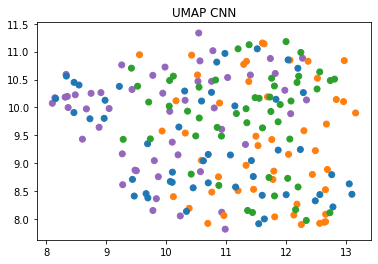

In [74]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(vectors)

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in vector_targets])
plt.gca().set_aspect('auto','box')
plt.title('UMAP CNN', fontsize=12);
plt.savefig('graphs/umap_variance_saturation,brightness,hue_allgenres.png', dpi = 100)

In [75]:
dominant_color = pd.read_csv('dominant_color.csv')

In [76]:
meta_targets = meta['genre'].map(d, na_action='ignore')

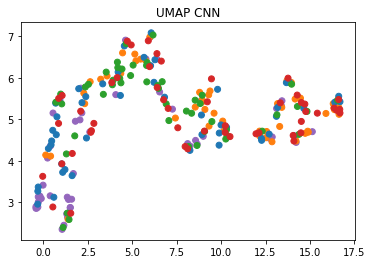

In [77]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(dominant_color)

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in meta_targets])
plt.gca().set_aspect('auto','box')
plt.title('UMAP CNN', fontsize=12);
plt.savefig('graphs/umap_variance_saturation,brightness,hue_allgenres.png', dpi = 100)